In [1]:
from qepy import *
from yambopy import *
from qepy import PwIn
import matplotlib.pyplot as plt
import numpy as np
import Routines as R

# Convergence analysis of the self-consistent QE computation

We study the convergence of the self-consistent computation for the determination of the ground state density. The relevant convergence parameteres are the number of k-points and the cutoff on the plane wave expansion

In [2]:
reload(R)
scf_kpoints = [2,3,4,5,6]
scf_ecut = [10,15,20,25,30] #eV
scfDict = R.buildScf(scf_kpoints,scf_ecut)

In [3]:
R.runScf(scfDict,8,True)

skip the computation for : scf/output/k2_ecut10.log
skip the computation for : scf/output/k2_ecut15.log
skip the computation for : scf/output/k2_ecut20.log
skip the computation for : scf/output/k2_ecut25.log
skip the computation for : scf/output/k2_ecut30.log
skip the computation for : scf/output/k3_ecut10.log
skip the computation for : scf/output/k3_ecut15.log
skip the computation for : scf/output/k3_ecut20.log
skip the computation for : scf/output/k3_ecut25.log
skip the computation for : scf/output/k3_ecut30.log
skip the computation for : scf/output/k4_ecut10.log
skip the computation for : scf/output/k4_ecut15.log
skip the computation for : scf/output/k4_ecut20.log
skip the computation for : scf/output/k4_ecut25.log
skip the computation for : scf/output/k4_ecut30.log
skip the computation for : scf/output/k5_ecut10.log
skip the computation for : scf/output/k5_ecut15.log
skip the computation for : scf/output/k5_ecut20.log
skip the computation for : scf/output/k5_ecut25.log
skip the com

In [4]:
# add the energy field to scfDict
for k in scfDict:
    for e in scfDict[k]:
        scfDict[k][e]['energy'] = R.get_totalEnergy(scfDict[k][e]['outputFile'])

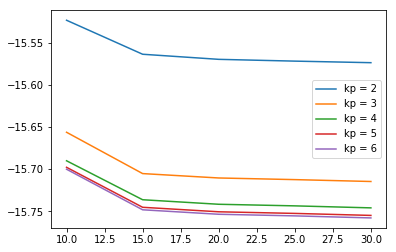

In [5]:
# plot the total energy in function of the ecut for each choice of kpoints
for k in scf_kpoints:
    energy = []
    for e in scf_ecut:
        energy.append(scfDict[k][e]['energy'])
    plt.plot(scf_ecut,energy,label= 'kp = '+str(k))
plt.legend()
plt.show()
    

We choose kpoints = 6 and ecut = 30 as convergence parameters of the scf computation

In [6]:
scf_kconv = 6
scf_ecutconv = 30

## QE nscf simulations

We perform a bunch of nscf simulations starting from the results of the scf one with converged parameters.

Nscf simulations use the same value of the ecut parameter found in converged scf computation are performed parametrically in terms of the quantities:

* nscf_kpoints
* nscf_nbnds

In [7]:
nscf_kpoints = [2,4,6,8]
# probably it will be sufficient to give to the nscf_bnds only a single (high) value and
# the parametric run will be done at the subsequent levels
nscf_nbnds = [60]

In [8]:
reload(R)
nscfDict = R.buildNscf(nscf_kpoints,nscf_nbnds,scf_kconv,scf_ecutconv)
#nscfDict

execute : cp -r scf/output/k6_ecut30.save nscf/output/
execute : mv  nscf/output/k6_ecut30.save nscf/output/k2_nb60.save
execute : cp -r scf/output/k6_ecut30.save nscf/output/
execute : mv  nscf/output/k6_ecut30.save nscf/output/k4_nb60.save
execute : cp -r scf/output/k6_ecut30.save nscf/output/
execute : mv  nscf/output/k6_ecut30.save nscf/output/k6_nb60.save
execute : cp -r scf/output/k6_ecut30.save nscf/output/
execute : mv  nscf/output/k6_ecut30.save nscf/output/k8_nb60.save


In [9]:
R.runNscf(nscfDict,8,True)

execute : mpirun -np 8 pw.x -inp nscf/input/k2_nb60.nscf > nscf/output/k2_nb60.log
execute : mpirun -np 8 pw.x -inp nscf/input/k4_nb60.nscf > nscf/output/k4_nb60.log
execute : mpirun -np 8 pw.x -inp nscf/input/k6_nb60.nscf > nscf/output/k6_nb60.log
execute : mpirun -np 8 pw.x -inp nscf/input/k8_nb60.nscf > nscf/output/k8_nb60.log


Prepare the system for the yambo computation. Run p2y and yambo (without options) in all the .save folders
generated by the nscf simulations

In [10]:
R.runP2y(nscfDict)

execute : cd nscf/output/k2_nb60.save;p2y;yambo
execute : cd nscf/output/k4_nb60.save;p2y;yambo
execute : cd nscf/output/k6_nb60.save;p2y;yambo
execute : cd nscf/output/k8_nb60.save;p2y;yambo


## Convergence analysis of various approximations for the self energy

Create the high-level yambo folder. For each choice of the nscf parameters create a folder with the name kp_#k_nb#nbnds and the copy the corresponding SAVE directory in the associated folder and perform a nscf QE computation in this folder. 

Structure of the yambo dictionary:

yambo[nscf_kpoints][nscf_nbnds] = {}

This dictionary has a key 'folder' that identifies the folder in which the subsequent yambo
computations are performed and a set of keys like 'hf', 'cosex',.... that contains a further dictionaries with the parameters and results of the different levels of yambo computations 

In [11]:
reload(R)
yamboDic = R.buildYambo(nscfDict)
#yamboDic

execute : cp -r nscf/output/k8_nb60.save/SAVE yambo/k8_nb60
execute : cp -r nscf/output/k2_nb60.save/SAVE yambo/k2_nb60
execute : cp -r nscf/output/k4_nb60.save/SAVE yambo/k4_nb60
execute : cp -r nscf/output/k6_nb60.save/SAVE yambo/k6_nb60


### HF approximation of $\Sigma$

In the HF approximation the self energy does not depend from the number of empty bands (only the occupied orbitals are relevant), so we perform a bunch of HF simulations varying the nscf_kpoints parameter and using only the first value of nscf_nbnds

HF computations performed in function of the parameter G0_Gcomp that expresses (in mHa) the cutoff value of the plane wave expansion of G0

In [29]:
G0_Gcomp = [.5,1.0,1.5,2.0,2.5]  #Ha
# compute the HF correction only for the bands in the range
firstbnd = 3
lastbnd = 6

Build the input file and prepare yamboDic

In [31]:
reload(R)
R.buildHF(yamboDic,G0_Gcomp,firstbnd,lastbnd)
#yamboDic

In [32]:
# run the HF simulations
R.runHF(yamboDic,8,True)
#yamboDic

execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F hf_gComp0.5.in -J hf_gComp0.5 -C hf_gComp0.5
execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F hf_gComp1.0.in -J hf_gComp1.0 -C hf_gComp1.0
execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F hf_gComp2.0.in -J hf_gComp2.0 -C hf_gComp2.0
execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F hf_gComp1.5.in -J hf_gComp1.5 -C hf_gComp1.5
execute : cd yambo/k2_nb60 ; mpirun -np 8 yambo -F hf_gComp2.5.in -J hf_gComp2.5 -C hf_gComp2.5
execute : cd yambo/k4_nb60 ; mpirun -np 8 yambo -F hf_gComp0.5.in -J hf_gComp0.5 -C hf_gComp0.5
execute : cd yambo/k4_nb60 ; mpirun -np 8 yambo -F hf_gComp1.0.in -J hf_gComp1.0 -C hf_gComp1.0
execute : cd yambo/k4_nb60 ; mpirun -np 8 yambo -F hf_gComp2.0.in -J hf_gComp2.0 -C hf_gComp2.0
execute : cd yambo/k4_nb60 ; mpirun -np 8 yambo -F hf_gComp1.5.in -J hf_gComp1.5 -C hf_gComp1.5
execute : cd yambo/k4_nb60 ; mpirun -np 8 yambo -F hf_gComp2.5.in -J hf_gComp2.5 -C hf_gComp2.5
execute : cd yambo/k6_nb60 ; mpirun -np 

In [33]:
# reads the results
R.getHFresults(yamboDic)

read file : yambo/k8_nb60/hf_gComp0.5/o-hf_gComp0.5.hf
read file : yambo/k8_nb60/hf_gComp1.0/o-hf_gComp1.0.hf
read file : yambo/k8_nb60/hf_gComp2.0/o-hf_gComp2.0.hf
read file : yambo/k8_nb60/hf_gComp1.5/o-hf_gComp1.5.hf
read file : yambo/k8_nb60/hf_gComp2.5/o-hf_gComp2.5.hf
read file : yambo/k2_nb60/hf_gComp0.5/o-hf_gComp0.5.hf
read file : yambo/k2_nb60/hf_gComp1.0/o-hf_gComp1.0.hf
read file : yambo/k2_nb60/hf_gComp2.0/o-hf_gComp2.0.hf
read file : yambo/k2_nb60/hf_gComp1.5/o-hf_gComp1.5.hf
read file : yambo/k2_nb60/hf_gComp2.5/o-hf_gComp2.5.hf
read file : yambo/k4_nb60/hf_gComp0.5/o-hf_gComp0.5.hf
read file : yambo/k4_nb60/hf_gComp1.0/o-hf_gComp1.0.hf
read file : yambo/k4_nb60/hf_gComp2.0/o-hf_gComp2.0.hf
read file : yambo/k4_nb60/hf_gComp1.5/o-hf_gComp1.5.hf
read file : yambo/k4_nb60/hf_gComp2.5/o-hf_gComp2.5.hf
read file : yambo/k6_nb60/hf_gComp0.5/o-hf_gComp0.5.hf
read file : yambo/k6_nb60/hf_gComp1.0/o-hf_gComp1.0.hf
read file : yambo/k6_nb60/hf_gComp2.0/o-hf_gComp2.0.hf
read file 

Analysis of the convergence of $\frac{EHF-E0}{E0}$ in function of the number of nscf_kpoints. Uses the first (and actually the only) value of the parameters nscf_nbnds and nscf_ecut

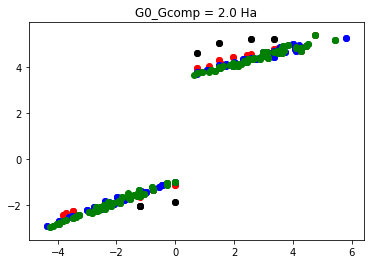

In [35]:
kp = yamboDic.keys()
kp.sort()
nb = nscf_nbnds[0]
gcomp = G0_Gcomp[3]

colors = ['black','red','blue','green']
for ind,k in enumerate(kp):
    y = yamboDic[k][nb]['hf'][gcomp]
    E0 = y['E0']
    EHF = y['EHF']
    for e0,ehf in zip(E0,EHF):
        plt.scatter(e0,ehf-e0,c = colors[ind])
plt.title('G0_Gcomp = '+str(gcomp)+' Ha')
plt.show()

Analysis of the convergence of the gap (both direct and indirect)

{0.5: [7.10625, 6.386489999999999, 6.17808, 6.1042000000000005], 1.0: [9.485418, 8.065083, 7.80304, 7.75383], 2.0: [9.645064, 8.221919, 7.956729999999999, 7.90791], 1.5: [9.645064, 8.221919, 7.956729999999999, 7.90791], 2.5: [9.645064, 8.221919, 7.956729999999999, 7.90791]}


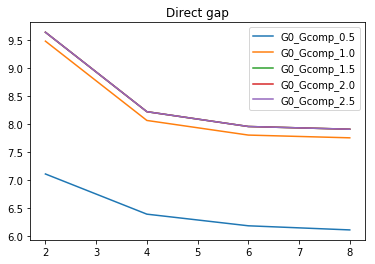

In [36]:
kp = yamboDic.keys()
kp.sort()
nb = nscf_nbnds[0]

dirGap = {}
for gcomp in G0_Gcomp:
    dirGap[gcomp] = []
    for k in kp:
        y = yamboDic[k][nb]['hf'][gcomp]
        ind = 0
        for kVal,bndVal in zip(y['KP'],y['BND']):
            if kVal == 1.0 and bndVal == 4.0:
                break
            else:
                ind +=1
        EHomo = y['EHF'][ind]
        ind = 0
        for kVal,bndVal in zip(y['KP'],y['BND']):
            if kVal == 1.0 and bndVal == 5.0:
                break
            else:
                ind +=1
        ELumo = y['EHF'][ind]
        dirGap[gcomp].append(ELumo-EHomo)

    plt.plot(kp,dirGap[gcomp],label= 'G0_Gcomp_'+str(gcomp))

print dirGap
plt.title('Direct gap')
plt.legend()
plt.show()

{0.5: [4.190971, 3.4792759999999996, 3.2359999999999998, 3.17915], 1.0: [7.009006, 5.544094, 5.25633, 5.201569999999999], 2.0: [7.236236, 5.796481999999999, 5.50848, 5.45609], 1.5: [7.236236, 5.796481999999999, 5.50848, 5.45609], 2.5: [7.236236, 5.796481999999999, 5.50848, 5.45609]}


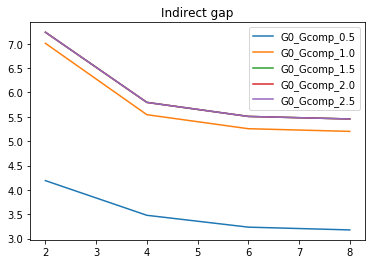

In [37]:
kp = yamboDic.keys()
kp.sort()
nb = nscf_nbnds[0]

# stucture for indirect gap [k] : [khomo,klumo]
# using indGap as difference between homo in Gamma(0,0,0) 
# and lumo in (0.0, -0.5, -0.5) (rlu)
par = {2:[1,3], 4:[1,7], 6:[1,13], 8:[1,21]}

indirGap = {}
for gcomp in G0_Gcomp:
    indirGap[gcomp] = []
    for k in kp:
        y = yamboDic[k][nb]['hf'][gcomp]
        ind = 0
        for kVal,bndVal in zip(y['KP'],y['BND']):
            if kVal == par[k][0] and bndVal == 4.0:
                break
            else:
                ind +=1
        EHomo = y['EHF'][ind]
        ind = 0
        for kVal,bndVal in zip(y['KP'],y['BND']):
            if kVal == par[k][1] and bndVal == 5.0:
                break
            else:
                ind +=1
        ELumo = y['EHF'][ind]
        indirGap[gcomp].append(ELumo-EHomo)

    plt.plot(kp,indirGap[gcomp],label= 'G0_Gcomp_'+str(gcomp))

print indirGap
plt.title('Indirect gap')
plt.legend()
plt.show()

This plots conclude the convergence analysis of the HF approximation of the self-energy. On the basis of this analysis we choose the convergence values of the kpoints and G0_gcomp parameters:

In [38]:
hf_kconv = 8
hf_G0_Gcompconv = 2.5 #Ha

### COHSEX approximation (without empties) of $\Sigma$

As a first step work in the approximation "without empty "bands". So we do not add the contribution of conduction bands for the evaluation of the Green function.
The evaluation of $W$ passes through:
$$
\chi = \chi_0 + \chi_0(v_H+f_{xc})\chi \\
W = v+v\chi v
$$
In the COHSEX one considers only the static contribution of the response $\chi(\omega=0)$ and we also limit our analysis to the Hartree kernel, so that $f_{xc}=0$ (RPA approximations).

In the COHSEX approximation (without empties) G0 still depends only from the number of kpoints and from the G0_Gcomp parameter. However in this case one introduces also a non trivial W potential and two more parameters come into the play. These are the cut of in the plane wave expansion of W and the number of empty bands used to write the Lehmann representation of $\chi_0$.

In [56]:
W_Gcomp = [0.5,1.0,1.5,2.0,3.0,4.0,5.0] #Ha
W_nb = [10,20,30,40]
# compute the COHSEX correction only for the bands in the range
firstbnd = 3
lastbnd = 6

In [57]:
reload(R)
R.buildCOHSEX(yamboDic,hf_kconv,hf_G0_Gcompconv,W_Gcomp,W_nb,firstbnd,lastbnd)
#yamboDic[hf_kconv][nscf_nbnds[0]]['cs']

In [58]:
R.runCOHSEX(yamboDic,hf_kconv,8,True)

skip the computation for : yambo/k8_nb60/cs_wGcomp0.5_wNb20/o-cs_wGcomp0.5_wNb20.qp
skip the computation for : yambo/k8_nb60/cs_wGcomp1.5_wNb20/o-cs_wGcomp1.5_wNb20.qp
skip the computation for : yambo/k8_nb60/cs_wGcomp0.5_wNb10/o-cs_wGcomp0.5_wNb10.qp
execute : cd yambo/k8_nb60 ; mpirun -np 8 yambo -F cs_wGcomp0.5_wNb30.in -J cs_wGcomp0.5_wNb30 -C cs_wGcomp0.5_wNb30
skip the computation for : yambo/k8_nb60/cs_wGcomp1.0_wNb20/o-cs_wGcomp1.0_wNb20.qp
execute : cd yambo/k8_nb60 ; mpirun -np 8 yambo -F cs_wGcomp5.0_wNb30.in -J cs_wGcomp5.0_wNb30 -C cs_wGcomp5.0_wNb30
skip the computation for : yambo/k8_nb60/cs_wGcomp3.0_wNb10/o-cs_wGcomp3.0_wNb10.qp
execute : cd yambo/k8_nb60 ; mpirun -np 8 yambo -F cs_wGcomp2.0_wNb30.in -J cs_wGcomp2.0_wNb30 -C cs_wGcomp2.0_wNb30
skip the computation for : yambo/k8_nb60/cs_wGcomp3.0_wNb20/o-cs_wGcomp3.0_wNb20.qp
skip the computation for : yambo/k8_nb60/cs_wGcomp1.0_wNb10/o-cs_wGcomp1.0_wNb10.qp
execute : cd yambo/k8_nb60 ; mpirun -np 8 yambo -F cs_wGcomp1

In [59]:
# reads the results
reload(R)
R.getCOHSEXresults(yamboDic,hf_kconv)

read file : yambo/k8_nb60/cs_wGcomp0.5_wNb20/o-cs_wGcomp0.5_wNb20.qp
read file : yambo/k8_nb60/cs_wGcomp1.5_wNb20/o-cs_wGcomp1.5_wNb20.qp
read file : yambo/k8_nb60/cs_wGcomp0.5_wNb10/o-cs_wGcomp0.5_wNb10.qp
read file : yambo/k8_nb60/cs_wGcomp0.5_wNb30/o-cs_wGcomp0.5_wNb30.qp
read file : yambo/k8_nb60/cs_wGcomp1.0_wNb20/o-cs_wGcomp1.0_wNb20.qp
read file : yambo/k8_nb60/cs_wGcomp5.0_wNb30/o-cs_wGcomp5.0_wNb30.qp
read file : yambo/k8_nb60/cs_wGcomp3.0_wNb10/o-cs_wGcomp3.0_wNb10.qp
read file : yambo/k8_nb60/cs_wGcomp2.0_wNb30/o-cs_wGcomp2.0_wNb30.qp
read file : yambo/k8_nb60/cs_wGcomp3.0_wNb20/o-cs_wGcomp3.0_wNb20.qp
read file : yambo/k8_nb60/cs_wGcomp1.0_wNb10/o-cs_wGcomp1.0_wNb10.qp
read file : yambo/k8_nb60/cs_wGcomp1.5_wNb40/o-cs_wGcomp1.5_wNb40.qp
read file : yambo/k8_nb60/cs_wGcomp4.0_wNb10/o-cs_wGcomp4.0_wNb10.qp
read file : yambo/k8_nb60/cs_wGcomp2.0_wNb20/o-cs_wGcomp2.0_wNb20.qp
read file : yambo/k8_nb60/cs_wGcomp3.0_wNb30/o-cs_wGcomp3.0_wNb30.qp
read file : yambo/k8_nb60/cs_wGcom

Analysis of the convergence of the gap (both direct and indirect)

{40: [3.7172799999999997, 3.184627, 3.385008, 3.385008, 3.591203, 3.6816709999999997, 3.702071], 10: [3.736128, 3.334508, 3.4925189999999997, 3.4925189999999997, 3.641484, 3.6794520000000004, 3.683375], 20: [3.7180720000000003, 3.209378, 3.400489, 3.400489, 3.5843100000000003, 3.6498039999999996, 3.6604469999999996], 30: [3.717465, 3.192735, 3.3914679999999997, 3.3914679999999997, 3.591533, 3.67345, 3.6900239999999997]}


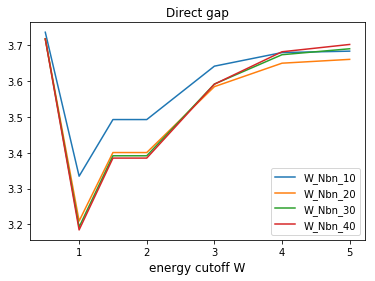

In [60]:
y = yamboDic[hf_kconv][nscf_nbnds[0]]['cs']

dirGap = {}
for wn in W_nb:
    dirGap[wn] = []
    for wg in W_Gcomp:    
        ind = 0
        for kVal,bndVal in zip(y[wg,wn]['KP'],y[wg,wn]['BND']):
            if kVal == 1.0 and bndVal == 4.0:
                break
            else:
                ind +=1
        EHomo = y[wg,wn]['E0'][ind] + y[wg,wn]['EmE0'][ind]
        ind = 0
        for kVal,bndVal in zip(y[wg,wn]['KP'],y[wg,wn]['BND']):
            if kVal == 1.0 and bndVal == 5.0:
                break
            else:
                ind +=1
        ELumo = y[wg,wn]['E0'][ind] + y[wg,wn]['EmE0'][ind]
        dirGap[wn].append(ELumo-EHomo)

    plt.plot(W_Gcomp,dirGap[wn],label= 'W_Nbn_'+str(wn))

print dirGap
plt.xlabel('energy cutoff W',size=12)
plt.title('Direct gap')
plt.legend()
plt.show()

{40: [1.288503, 0.94477, 1.2851949999999999, 1.2851949999999999, 1.559924, 1.6794850000000001, 1.705066], 10: [1.3053919999999999, 1.119288, 1.36578, 1.36578, 1.544686, 1.58837, 1.59295], 20: [1.2892279999999998, 0.985928, 1.299202, 1.299202, 1.5352140000000003, 1.616129, 1.6285820000000002], 30: [1.2886769999999999, 0.95806, 1.290937, 1.290937, 1.5531160000000002, 1.6580469999999998, 1.6780559999999998]}


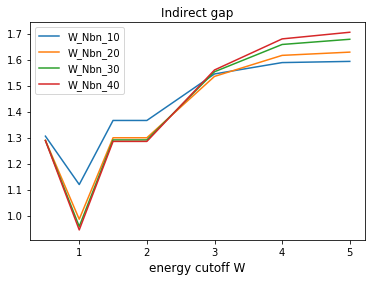

In [61]:
y = yamboDic[hf_kconv][nscf_nbnds[0]]['cs']

# stucture for indirect gap [k] : [khomo,klumo]
# using indGap as difference between homo in Gamma(0,0,0) 
# and lumo in (0.0, -0.5, -0.5) (rlu)
par = {2:[1,3], 4:[1,7], 6:[1,13], 8:[1,21]}

indirGap = {}
for wn in W_nb:
    indirGap[wn] = []
    for wg in W_Gcomp:    
        ind = 0
        for kVal,bndVal in zip(y[wg,wn]['KP'],y[wg,wn]['BND']):
            if kVal == par[hf_kconv][0] and bndVal == 4.0:
                break
            else:
                ind +=1
        EHomo = y[wg,wn]['E0'][ind] + y[wg,wn]['EmE0'][ind]
        ind = 0
        for kVal,bndVal in zip(y[wg,wn]['KP'],y[wg,wn]['BND']):
            if kVal == par[hf_kconv][1] and bndVal == 5.0:
                break
            else:
                ind +=1
        ELumo = y[wg,wn]['E0'][ind] + y[wg,wn]['EmE0'][ind]
        indirGap[wn].append(ELumo-EHomo)

    plt.plot(W_Gcomp,indirGap[wn],label= 'W_Nbn_'+str(wn))

print indirGap
plt.xlabel('energy cutoff W',size=12)
plt.title('Indirect gap')
plt.legend()
plt.show()